Loading and unloading of a viscoelastic half-space
======

Loading of Earth's surface can be described with an initial periodic surface displacement of a viscous fluid within an infinite half space, the solution of which is outlined in Turcotte and Schubert (1982), 6-10.  The surface decreases exponentially with time and is dependent on the magnitude, $w_m$, and wavelength $\lambda$ of the perturbation, and the viscosity, $\eta$ and density, $\rho$ of the fluid,

$$ w = w_m exp\Big(\frac{-\lambda \rho g t}{4\pi\eta}\Big) $$

where $w$ is displacement, $w_m$ the initial load magnitude, $g$ gravity, $t$ time. This solution can be charaterised by the relaxation time, $t_{visc} = 4\pi\eta / \rho g \lambda $, the time taken for the initial load to decrease by $e^{-1}$. The solution for an elastic material with the equivalent load produces the same magnitude of displacement instantaneously.


In [1]:
%matplotlib inline
import UWGeodynamics as GEO
import numpy as np

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Analytical solution

In [3]:
# model domain
minX = -200.0e3 * u.meter
maxX =  200.0e3 * u.meter
minY = - 80.0e3 * u.meter
maxY =   20.0e3 * u.meter

# model parameters
density   = 3300 * u.kilogram / u.metre**3 
gravity   = 9.81 * u.meter / u.second**2

In [4]:
# material parameters
eta  =   1e21 * (u.kilogram * u.meter**-1 * u.second**-2) * u.second # viscosity of fluid (mantle)
mu   = 100e9  * (u.kilogram * u.meter**-1 * u.second**-2)            # shear modulus

alpha    = eta / mu            # Maxwell relaxation time
dt_e     = 120e3 * 3.15569e7 * u.seconds     # equivalent to t_visc, the load relaxation time

eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # for viscoelastic implementation

print "Maxwell relaxation time = ", alpha.to(u.year), alpha
print "Observation time        = ", dt_e.to(u.year), dt_e
print "effective viscosity     = ", eta_eff.to(u.pascal * u.second)

Maxwell relaxation time =  316.887646408 year 10000000000.0 second
Observation time        =  119999.901227 year 3.786828e+12 second
effective viscosity     =  9.97366222542e+20 pascal * second


In [5]:
# Initial Load Magnitude and wavelength
w_m    =   5.0 * u.kilometer # displacement magnitue, << Lambda
Lambda = 100.0 * u.kilometer # displacement wavelength

In [6]:
# analytic solution
xMax = maxX - minX
x = np.linspace(0, xMax.magnitude, 100+1)

# initial displacement
w_0 = w_m * np.cos(2.*np.pi*(x*u.meter)/Lambda)

In [7]:
# viscous relaxation of load
t_relax = 4 * np.pi * eta / (Lambda * density * gravity)
tMax = (t_relax * 5).to_base_units()

# deflection with time of viscous solution
t = np.linspace(0, tMax.magnitude, 100 * 10 + 1)
t *= u.second
w_t = w_m * np.exp(-1.*t/t_relax)

# Scaling

In [8]:
# Characteristic values of the system
model_height = maxY-minY
# refViscosity = asth_visc 
bodyforce = density * gravity

KL = model_height 
Kt = t_relax
KM = bodyforce * KL**2 * Kt**2

In [9]:
GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [10]:
Model = GEO.Model(elementRes=(128, 32),
                  minCoord=(minX, minY),
                  maxCoord=(maxX, maxY),
                  periodic=[True, False], 
                  gravity=[0., -1.0 * gravity])

In [11]:
Model.outputDir="ViscoElastic"

## Materials

In [12]:
air = Model.add_material(name="Air")
mantle = Model.add_material(name="Mantle")

In [13]:
import underworld.function as fn

coords = fn.input()
perturbation = GEO.nd(w_m) * fn.math.cos(2. * np.pi * coords[0] / GEO.nd(Lambda))

conditions = [(coords[1] < perturbation, mantle.index),
              (True, air.index)]
                                        
Model.materialField.data[:] = fn.branching.conditional(conditions).evaluate(Model.swarm)

## Densities

In [14]:
air.density = 0.1 * u.kilogram / u.meter**3
mantle.density = 3300 * u.kilogram / u.metre**3 

## Viscosities

In [15]:
air.viscosity = 1e18 * u.pascal * u.second
mantle.viscosity = 1e21 * u.pascal * u.second

In [16]:
mantle.elasticity = GEO.Elasticity(shear_modulus=0.1 * u.gigapascal, 
                                   observation_time=120000. * u.years)

## Velocity Boundary conditions

In [17]:
Model.set_velocityBCs(top=[0,0], bottom=[0,0])

## Passive Tracers

In [18]:
x = np.linspace(GEO.nd(minX), GEO.nd(maxX), 201)
y = GEO.nd(w_m) * np.cos(2. * np.pi * x / GEO.nd(Lambda))

tracerSurface = Model.add_passive_tracers(name="Tracer Swarm", vertices=[x, y])
tracerSolo = Model.add_passive_tracers(name="Single Tracer", vertices=[0., GEO.nd(w_m)])

## Visualisation


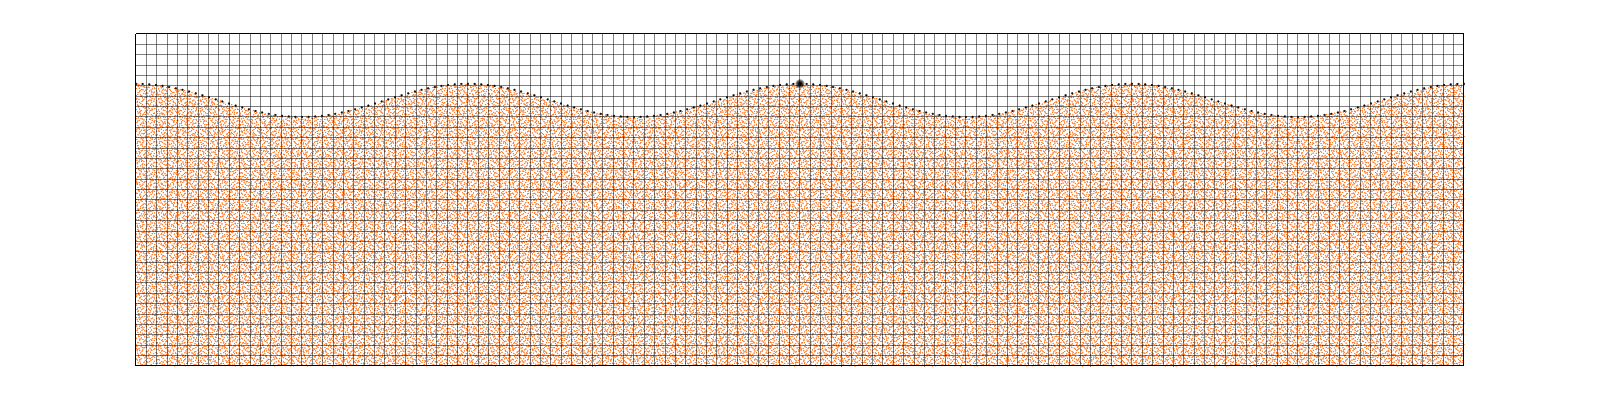

In [19]:
import glucifer

materialFilter = Model.materialField > 1

figMaterial = glucifer.Figure(figsize=(1600,400))
figMaterial.Mesh(Model.mesh,opacity=0.5)
figMaterial.Points(Model.passive_tracers[0].swarm, pointSize=3, colourBar=False)
figMaterial.Points(Model.passive_tracers[1].swarm, pointSize=10, colourBar=False)
figMaterial.Points(Model.swarm, Model.materialField, fn_mask=materialFilter, 
                   pointSize=2, colourBar=False, valueRange=[0,1])
figMaterial.show()

In [20]:
GEO.rcParams["solver"] = "lu"

In [21]:
tTracer      = [GEO.nd(Model.time)]
displacement = [GEO.nd(tracerSolo.swarm.particleCoordinates.data[0][1])]

def postSolveHook():
    global tTracer, displacement
    tTracer.append(GEO.nd(Model.time))
    displacement.append(GEO.nd(tracerSolo.swarm.particleCoordinates.data[0][1]))

In [22]:
Model.postSolveHook = postSolveHook

In [23]:
Model.run_for(600000. * u.years)

Time:  3690.39104147 year dt: 3690.39104147 year
Time:  7877.84943205 year dt: 4187.45839058 year
Time:  12837.2734796 year dt: 4959.42404758 year
Time:  18403.6620338 year dt: 5566.38855413 year
Time:  25731.3770506 year dt: 7327.71501683 year
Time:  34432.1233417 year dt: 8700.7462911 year
Time:  44988.7502864 year dt: 10556.6269447 year
Time:  60897.0048183 year dt: 15908.2545319 year
Time:  84237.9607047 year dt: 23340.9558864 year
Time:  117486.794534 year dt: 33248.8338293 year
Time:  149422.882251 year dt: 31936.0877173 year
Time:  189422.882251 year dt: 40000.0 year
Time:  222070.582662 year dt: 32647.7004103 year
Time:  247281.794627 year dt: 25211.2119659 year
Time:  287281.794627 year dt: 40000.0 year
Time:  327281.794627 year dt: 40000.0 year
Time:  354663.469146 year dt: 27381.6745189 year
Time:  392083.409314 year dt: 37419.9401674 year
Time:  432083.409314 year dt: 40000.0 year
Time:  472083.409314 year dt: 40000.0 year
Time:  506494.504331 year dt: 34411.095017 year
Tim

1


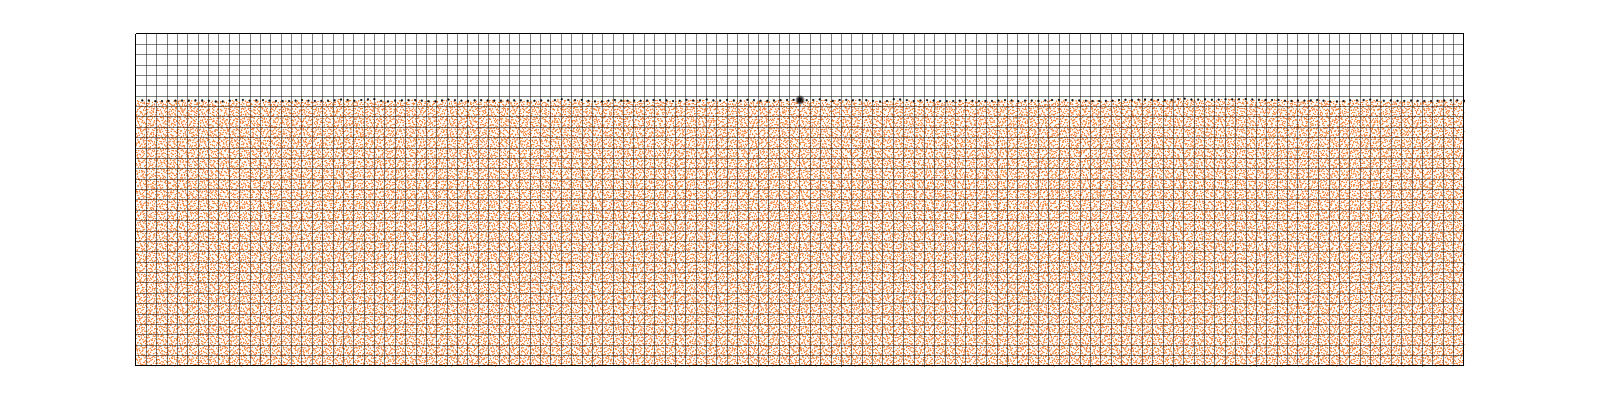

In [24]:
figMaterial.show()

# Analysis

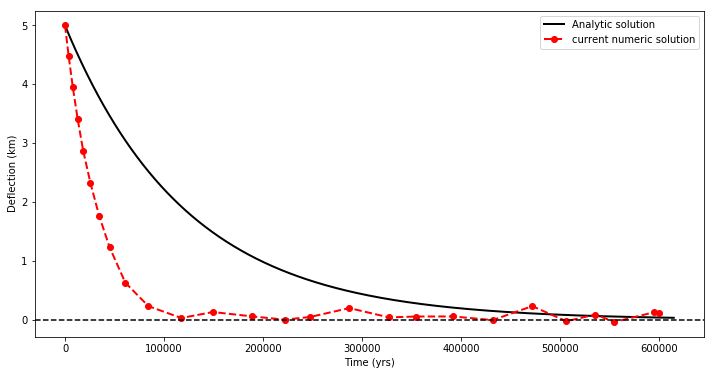

In [25]:
import pylab as plt

fig, (ax) = plt.subplots(1, 1)
fig.set_size_inches(12, 6) 
ax.plot(t.to(u.years), w_t.to(u.kilometer),
         label='Analytic solution', color="k",
         linestyle="-", linewidth=2)
ax.plot(GEO.Dimensionalize(tTracer, u.years),
        GEO.Dimensionalize(displacement, u.kilometer), 
        label='current numeric solution', color="red",
        linestyle="--", marker="o", linewidth=2)
ax.axhline(0.,color='black',linestyle='--')
ax.axis(ticklabel_format='sci')
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Deflection (km)')
ax.legend(loc='best')
plt.show()